## Vision transformers

Outline:
- Fill in model architecture (maybe ask them to implement attention by hand? might be too hard)
- Load pretrained weights
- Load ImageNet
- Fine-tune on ImageNet (write training loop)

## Vision transformer architecture

First, go to **vit_architecture.py** and fill in some model definitions. You might find this illustration of the architecture of a vision transformer helpful (Figure 1 from the [ViT paper](https://arxiv.org/pdf/2010.11929.pdf)).

![](vit_architecture.png)

Once you complete all the TODOs, run the cell below to import the model.

In [63]:
%load_ext autoreload
%autoreload 2

from vit_architecture_solutions import VisionTransformer
# from vit_architecture import VisionTransformer

config = {
    "num_classes": 10,
    "patch_size": 16,
    "hidden_size": 384,
    "model_name": 'ViT-S_16',
}

transformer_config = {
    "mlp_dim": 1536,
    "num_heads": 6,
    "num_layers": 12,
    "attention_dropout_rate": 0.0,
    "dropout_rate": 0.0,
}

model = VisionTransformer(
    num_classes=config["num_classes"], 
    patch_size=config["patch_size"],
    hidden_size=config["hidden_size"],
    model_name=config["model_name"],
    transformer_config=transformer_config,
)

model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


VisionTransformer(
    # attributes
    num_classes = 10
    patch_size = 16
    hidden_size = 384
    transformer_config = {'mlp_dim': 1536, 'num_heads': 6, 'num_layers': 12, 'attention_dropout_rate': 0.0, 'dropout_rate': 0.0}
    cls_head_bias_init = 0.0
    model_name = 'ViT-S_16'
)

## Load pre-trained weights

In [64]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import flax
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import einops
from tqdm import tqdm
from vit_utils import load_pretrained, get_cifar10, NumpyLoader, one_hot, accuracy
jax.local_devices() # shows available devices

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [65]:
# Download pretrained S_16 checkpoint
checkpoint_file = "S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz"
if not os.path.exists("checkpoints"):
    os.system("mkdir checkpoints")
os.chdir("checkpoints")
if not os.path.exists(checkpoint_file):
    os.system(f"wget https://storage.googleapis.com/vit_models/augreg/{checkpoint_file}")
os.chdir("..")
with open(f"checkpoints/{checkpoint_file}", "rb") as f:
    ckpt_dict = np.load(f, allow_pickle=False)
    keys, values = zip(*list(ckpt_dict.items()))

# Initialize the model with random parameters
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    np.random.randn(2, 224, 224, 3),
    train=False,
), backend='cpu')()

In [66]:
# Load checkpoint
params = load_pretrained(
    pretrained_path=f'checkpoints/{checkpoint_file}',
    init_params=variables['params'],
)

## Load CIFAR-10

TODO: Also load ImageNet and check that performance is good on it out of the box.

In this section, we will fine-tune our vision transformer on CIFAR-10. CIFAR-10 is an image dataset with 10 classes. If you are not familiar with the dataset, you can read about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). Since our model was trained on ImageNet, a much bigger and more complex dataset, CIFAR-10 should be relatively easy.

First, let's load the dataset and check the model's performance before any fine-tuning.

Files already downloaded and verified
Files already downloaded and verified
Label: automobile


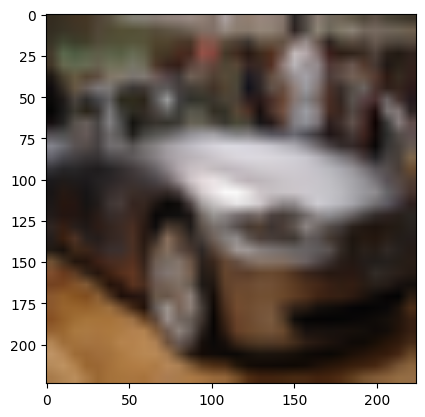

In [97]:
n_targets = 10
batch_size = 128
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get datasets from torchvision
cifar10_train, cifar10_test = get_cifar10()
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, pin_memory=True)

# Show an example image
for images, labels in train_loader:
    plt.imshow(einops.rearrange(images[0], "c h w -> h w c"))
    print(f"Label: {cifar10_labels[labels[0]]}")
    break

In [76]:
# This cell contains some JAX setup that you do not have to understand.

# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

params.cls: DeviceArray (10,)
params_repl.cls: ShardedDeviceArray (1, 10)


In [92]:
# Check the accuracy on CIFAR-10 without fine-tuning

def get_accuracy(params_repl, torch_loader: DataLoader):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  for image, label in tqdm(torch_loader):
      image = image.unsqueeze(0).numpy()
      image = einops.rearrange(image, "n b c h w -> n b h w c")
      # ---------- student TODO -----------
      predicted = vit_apply_repl(params_repl, image).squeeze()
      is_same = predicted.argmax(axis=-1) == label.numpy()
      good += is_same.sum()
      total += len(is_same.flatten())
      # -----------------------------------
  return good / total

get_accuracy(params_repl, test_loader)

100%|██████████| 79/79 [00:17<00:00,  4.48it/s]


DeviceArray(0.1, dtype=float32)

Question x: How is the model's performance on CIFAR-10 without any fine-tuning? Is this surprising?

## Fine-tune

Google notebook says fine-tuning on CIFAR takes 15 minutes on TPU. We could have students fine-tune the pre-trained the model and compare it with training a randomly initialized model from scratch for the same amount of time - I think they should get >97% post fine-tuning and not very different from random chance without the pretraining.